In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import compute_speed, compute_head_angle_to_pup, compute_distance_to_pup, extract_base_parameters, plot_mouse_angle_to_pup, convert_seconds_to_frame

## Reading and loading data ##

In [2]:
data_dir = "data"
DL = DataLoader(data_dir)

Found items ['.DS_Store', 'MBI5335RR'] at directory data
Found items ['.DS_Store', 'MBI5335RR_240309_d6', 'MBI5335RR_240305_d2', 'MBI5335RR_240304_d1', 'MBI5335RR_240308_d5', 'MBI5335RR_240306_d3', 'MBI5335RR_240307_d4'] at directory data/MBI5335RR
Found items ['MBI5335RR_240309_d6_Avisoft', 'MBI5335RR_240309_d6_Behavior'] at directory data/MBI5335RR/MBI5335RR_240309_d6
Found items ['MBI5335RR_240309_d6_Avisoft_concatenated 2024-04-21  2_08 PM_Stats_SYNCCORRECTED.xlsx'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Avisoft
Found items ['MBI5335RR_d6DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.csv', 'MBI5335RR_240309_d6_BehavSummary.csv'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior
Found items ['MBI5335RR_240305_d2_Behavior', 'MBI5335RR_240305_d2_Avisoft'] at directory data/MBI5335RR/MBI5335RR_240305_d2
Found items ['MBI5335RR_240305_d2_BehavSummary.csv', 'MBI5335RR_d2DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.

## Data Exploration ##

##### Day 1 trials #####

In [3]:
# get data for d1 experiment
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = "d1")

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']

In [ ]:
# create a grid of 1 x 2 plots
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ylim = max(df_DLC['msTop_y'].max(), df_DLC['pup_y'].max())
xlim = max(df_DLC['msTop_x'].max(), df_DLC['pup_x'].max())

# color the points with the time
df_DLC.iloc[1000:1500].plot(x='msTop_x', y='msTop_y', style='o', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'r')
df_DLC.iloc[1000:1500].plot(x='pup_x', y='pup_y', style='o', ax=ax,xlim=(0, xlim), ylim=(0, ylim), color = 'b')


In [ ]:
df_summary.head(3)
# find dtype of each column
#df_summary.dtypes

In [ ]:
df_DLC.head(3)
#df_DLC["time_seconds"]*30

## Feature Extraction ##

### BehavSummary + DLC  ###

- **BehavSummary + DLC**
    - Define behavioral windows (e.g: -2 to +2 seconds of each behavioral event)
    - Define behavioral windows pre-event (e.g: -x to 0 seconds of each behavioral event)
    - Find behavioral events (from BehavSummaries; *timing info*) in the DLC position data (*x,y info*):
        - at each behavioral event, where was the mouse and the pup located in the arena?
            - how far was the mouse from the pup?
            - what was the head direction of the mouse (towards the pup) at that point?
            - ‘approach’ trajectory: parse out trajectory of mouse towards pup and try to find a segment which is more ‘direct’/ higher speed
        - For the pre-event behavioral window of MouseFirstPickUpSecs: what is the speed of the mouse? What is the head direction of the mouse?

In [4]:
trial_1 = df_summary[df_summary['TrialNum'] == 1]

trial_1

BehavRecdTrialEndSecs = trial_1['BehavRecdTrialEndSecs'].values[0]
PupDispDropSecs = trial_1['PupDispDropSecs'].values[0]
MouseFirstPickUpPupSecs = trial_1['MouseFirstPickUpPupSecs'].values[0]
DropPupNestSecs = trial_1['DropPupNestSecs'].values[0]

# compute frame indices by rounding
BehavRecdTrialEndSecs_frame = convert_seconds_to_frame(BehavRecdTrialEndSecs)
PupDispDropSecs_frame = convert_seconds_to_frame(PupDispDropSecs)
MouseFirstPickUpPupSecs_frame = convert_seconds_to_frame(MouseFirstPickUpPupSecs)
DropPupNestSecs_frame = convert_seconds_to_frame(DropPupNestSecs)

 # print all the times
print("BehavRecdTrialEndSecs", "frame index",  BehavRecdTrialEndSecs_frame)
print("PupDispDropSecs", "frame index", PupDispDropSecs_frame)
print("MouseFirstPickUpPupSecs", "frame index", MouseFirstPickUpPupSecs_frame)
print("DropPupNestSecs", "frame index",  DropPupNestSecs_frame)

BehavRecdTrialEndSecs frame index 11538
PupDispDropSecs frame index 11072
MouseFirstPickUpPupSecs frame index 11468
DropPupNestSecs frame index 11538


In [6]:
start_frame = PupDispDropSecs_frame
end_frame = BehavRecdTrialEndSecs_frame

# print corresponding time in minutes
print("Start time in seconds:", str(datetime.timedelta(seconds=start_frame/30)))
print("End time in seconds:", str(datetime.timedelta(seconds=end_frame/30)))

# look at the dataframe with frame_index within in the window
mask = (df_DLC['frame_index'] >= start_frame) & (df_DLC['frame_index'] <= end_frame)
trial_1_DLC = df_DLC[mask]

Start time in seconds: 0:06:09.066667
End time in seconds: 0:06:24.600000


In [ ]:
trial_1_DLC.head(3)

Display full trial

In [ ]:
# plot mouse and pup positions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

xlim, ylim =  max(df_DLC['msTop_x'].max(), df_DLC['pup_x'].max()), max(df_DLC['msTop_y'].max(), df_DLC['pup_y'].max())

trial_1_DLC.plot(x='msTop_x', y='msTop_y', style='o', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'r')
trial_1_DLC.plot(x='pup_x', y='pup_y', style='o', ax=ax,xlim=(0, xlim), ylim=(0, ylim), color = 'b')

Speed

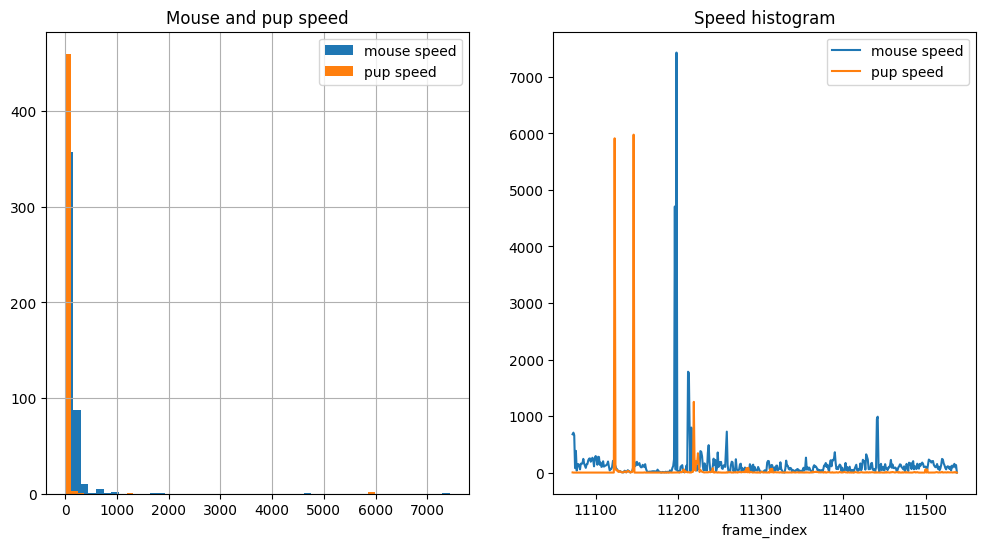

In [13]:
mouse_speed_col = 'mouse_speed_px/s'
pup_speed_col = 'pup_speed_px/s'
trial_1_DLC = compute_speed(trial_1_DLC, x_col = 'msTop_x', y_col = 'msTop_y', speed_col = mouse_speed_col)
trial_1_DLC = compute_speed(trial_1_DLC, x_col = 'pup_x', y_col = 'pup_y', speed_col = pup_speed_col)

# create a grid of 2 histogram plots one for mouse speed and one for pup speed
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# histogram of speed

trial_1_DLC[mouse_speed_col].hist(bins=50, ax=ax[0], label = 'mouse speed')
trial_1_DLC[pup_speed_col].hist(bins=50, ax=ax[0], label = 'pup speed')
ax[0].set_title('Mouse and pup speed')  # set title
ax[0].legend()  # show legend

# histogram of speed
trial_1_DLC.plot(x='frame_index', y=mouse_speed_col, ax=ax[1], label = 'mouse speed')
trial_1_DLC.plot(x='frame_index', y=pup_speed_col, ax=ax[1], label = 'pup speed')

ax[1].set_title('Speed histogram')  # set title
ax[1].legend()  # show legend


Distance to pup

Text(0.5, 1.0, 'Distance to pup')

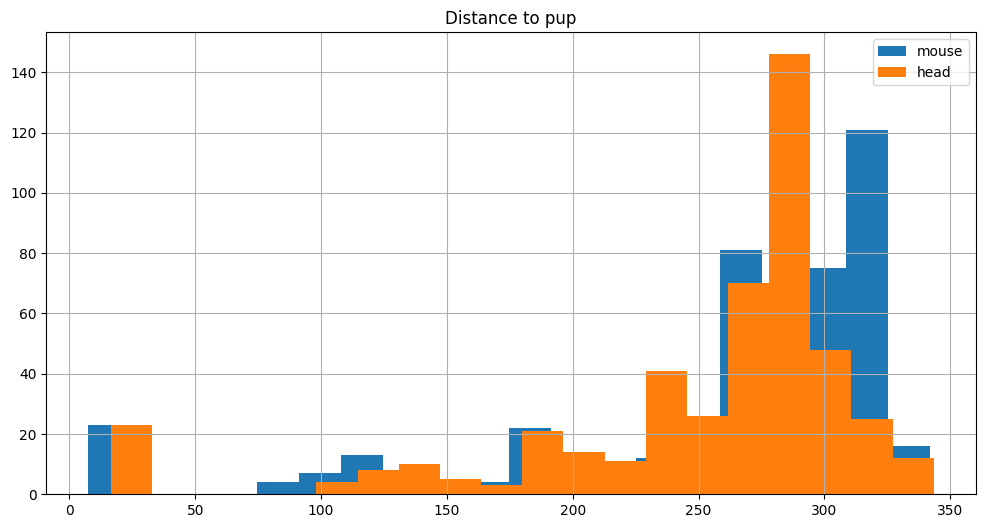

In [12]:
distance_mouse_to_pup = 'distance_mouse_to_pup'
distance_head_to_pup = 'distance_head_to_pup'

head_x_col, head_y_col = 'endHeadbar_x','endHeadbar_y'

trial_1_DLC = compute_distance_to_pup(trial_1_DLC, distance_col = distance_mouse_to_pup)
trial_1_DLC = compute_distance_to_pup(trial_1_DLC, distance_col = distance_head_to_pup, x_col = head_x_col, y_col = head_y_col)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

trial_1_DLC[distance_mouse_to_pup].hist(bins=20, ax=ax, label = 'mouse')
trial_1_DLC[distance_head_to_pup].hist(bins=20, ax=ax, label = 'head')

ax.legend()

ax.set_title('Distance to pup')  # set title

Head angle to pup

<Axes: >

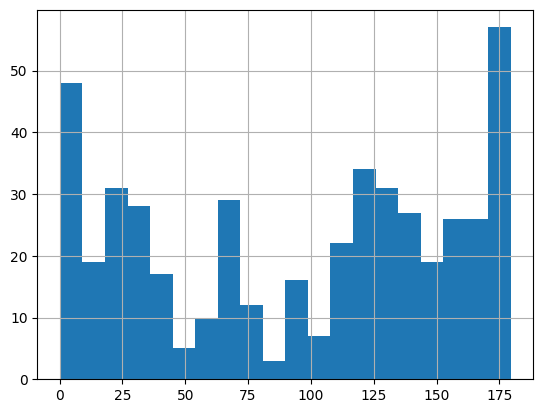

In [14]:
head_angle_to_pup_col = 'head_angle_to_pup_degrees'

trial_1_DLC = compute_head_angle_to_pup(trial_1_DLC, add_vector_columns = True, head_angle_to_pup_col=head_angle_to_pup_col)

trial_1_DLC[head_angle_to_pup_col].hist(bins=20)

Visualize head angle to pup

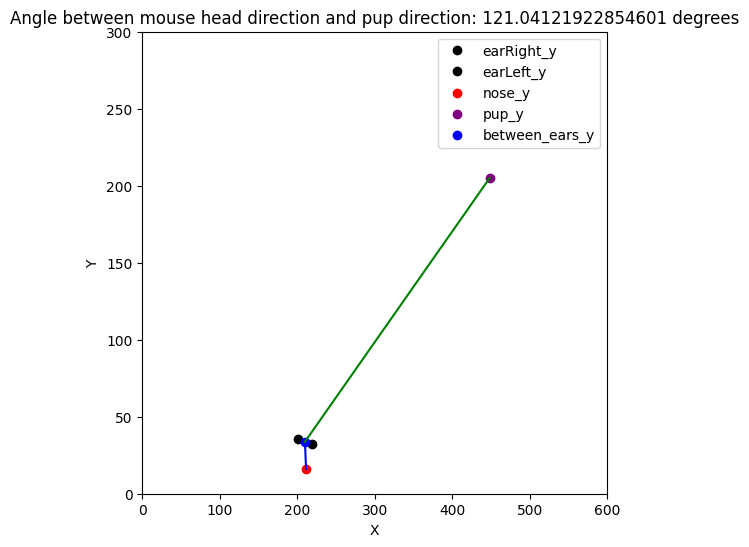

In [15]:
plot_mouse_angle_to_pup(trial_1_DLC, ylim = 300 , xlim = 600)

Process full file (df_DLC)

In [16]:
df_DLC_updated = extract_base_parameters(df_DLC, df_summary)

Processing trial 1 Start frame: 11072 End frame: 11538
Processing trial 2 Start frame: 11901 End frame: 12085
Processing trial 3 Start frame: 12456 End frame: 14848
Processing trial 4 Start frame: 15232 End frame: 15940
Processing trial 5 Start frame: 16418 End frame: 19682
Processing trial 6 Start frame: 19972 End frame: 20270
Processing trial 7 Start frame: 20600 End frame: 20923
Processing trial 8 Start frame: 21386 End frame: 21866
Processing trial 9 Start frame: 22212 End frame: 24358
Processing trial 10 Start frame: 24884 End frame: 25584


In [17]:
df_DLC_updated

,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,centerNest_y,centerNest_likelihood,pup_x,pup_y,pup_likelihood,ms_speed_px/s,pup_speed_px/s,distance_head_to_pup,distance_mouse_to_pup,head_angle_to_pup_degrees
151,151,5.033333,170.865509,89.811813,0.961542,190.735977,79.387955,0.943847,174.400299,80.521759,...,57.566437,0.910896,477.403198,251.108810,0.074489,NaN,NaN,NaN,NaN,NaN
152,152,5.066667,170.884583,89.919662,0.960909,190.975998,79.499725,0.941302,174.574753,80.326324,...,57.520256,0.904566,477.380341,251.101379,0.074293,NaN,NaN,NaN,NaN,NaN
153,153,5.100000,170.883240,90.323051,0.961621,191.376846,80.730232,0.936073,174.205078,80.630722,...,57.570263,0.890773,477.362000,251.079193,0.073658,NaN,NaN,NaN,NaN,NaN
154,154,5.133333,170.926773,90.564362,0.961369,191.282913,80.673759,0.933111,174.103851,80.784721,...,55.338409,0.897453,477.296814,251.060013,0.073508,NaN,NaN,NaN,NaN,NaN
155,155,5.166667,170.918793,90.485443,0.962388,191.297684,80.754738,0.930888,174.123138,80.792427,...,55.659248,0.909907,477.293640,251.065277,0.073560,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26036,26036,867.866667,209.939117,77.639259,0.145247,209.055069,75.931168,0.016676,210.217743,76.130127,...,71.425491,0.994742,480.212799,250.406647,0.063795,NaN,NaN,NaN,NaN,NaN
26037,26037,867.900000,207.269028,76.809303,0.025151,208.071136,76.504684,0.009770,209.278519,76.249054,...,68.849236,0.995682,480.212860,250.405945,0.064049,NaN,NaN,NaN,NaN,NaN
26038,26038,867.933333,208.179184,81.363785,0.282739,206.524475,80.659828,0.024828,208.075089,80.550095,...,72.999992,0.991961,480.213226,250.405502,0.064019,NaN,NaN,NaN,NaN,NaN
26039,26039,867.966667,209.563736,83.124634,0.252159,220.156143,78.939888,0.029228,208.904358,81.995323,...,73.347084,0.981267,480.216187,250.406601,0.063996,NaN,NaN,NaN,NaN,NaN


### Behavioural Windows (+/- 2s) around key events ###

In [17]:
def extract_feature_behavioural_window(behaviour_col, trial_num, df_DLC, df_summary, window_size = 60):

    # get the trial
    trial_metadata = df_summary[df_summary['TrialNum'] == trial_num]
    BehavRecdTrialEndSecs = trial_metadata['BehavRecdTrialEndSecs'].values[0]

    # nan check
    if np.isnan(BehavRecdTrialEndSecs):
        warnings.warn("BehavRecdTrialEndSecs is NaN")
        return None
    
    end_frame = convert_seconds_to_frame(BehavRecdTrialEndSecs)
    start_frame = BehavRecdTrialEndSecs_frame - window_size

    pass
    # return a slice of the dataframe with the features speed, head_angle, distance to pup, extracted

### Pre-event behavioural window (-Xs preceding key event) ###

In [18]:
def extract_feature_pre_event_window(behaviour_col, trial_num, df_DLC, df_summary, pre_event_window_size = 100):

    pass

### Analyzing parameters ###

In [19]:
def analyze_trajectory(df_DLC, start_frame, end_frame):
    
    print("Trajectory detected from frame {} to frame {}".format(start_frame, end_frame))
    